## Descarga Dataset

In [ ]:
import kagglehub
import os
import shutil

In [ ]:
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")
print("Path to dataset files:", path)

In [9]:
dir_act = os.getcwd()
for item in os.listdir(path):
    src = os.path.join(path, item)
    dst = os.path.join(dir_act, item)
    shutil.move(src, dst)

## Preparacion del entorno

In [1]:
import numpy as np
import pandas as pd
import gradio as gr
import os
import faiss
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Model
from tqdm import tqdm
from PIL import Image
from collections import Counter

/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-27 10:40:08.411026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751031608.429419  609227 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751031608.435343  609227 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751031608.450183  609227 computation_placer.cc:177] computation placer already registered. Please check linkage and a

In [2]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2025-06-27 10:40:10.446247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751031610.464709  609261 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751031610.470921  609261 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751031610.485262  609261 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751031610.485282  609261 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751031610.485287  609261 computation_placer.cc:177] computation placer alr

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Etapa 1: Buscador de Imágenes por Similitud

### Creación de la Base de Datos Vectorial:

#### Modelo base

In [4]:
# Cargar el CSV
df_dogs_breed = pd.read_csv("dogs.csv")

# Asegurar que las rutas sean correctas y completas
df_dogs_breed['full_path'] = df_dogs_breed['filepaths'].apply(lambda x: os.path.join(os.getcwd(), x))

# Filtrar solo imágenes existentes por seguridad
df_dogs_breed = df_dogs_breed[df_dogs_breed['full_path'].apply(os.path.exists)].reset_index(drop=True)

In [5]:
df_dogs_breed

filepaths  labels data set  \
0     train/Afghan/001.jpg  Afghan    train   
1     train/Afghan/002.jpg  Afghan    train   
2     train/Afghan/003.jpg  Afghan    train   
3     train/Afghan/004.jpg  Afghan    train   
4     train/Afghan/005.jpg  Afghan    train   
...                    ...     ...      ...   
9341   valid/Yorkie/06.jpg  Yorkie    valid   
9342   valid/Yorkie/07.jpg  Yorkie    valid   
9343   valid/Yorkie/08.jpg  Yorkie    valid   
9344   valid/Yorkie/09.jpg  Yorkie    valid   
9345   valid/Yorkie/10.jpg  Yorkie    valid   

                                              full_path  
0     /home/franco/Escritorio/TUIA/Computer Vision/C...  
1     /home/franco/Escritorio/TUIA/Computer Vision/C...  
2     /home/franco/Escritorio/TUIA/Computer Vision/C...  
3     /home/franco/Escritorio/TUIA/Computer Vision/C...  
4     /home/franco/Escritorio/TUIA/Computer Vision/C...  
...                                                 ...  
9341  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9342  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9343  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9344  /home/franco/Escritorio/TUIA/Computer Vision/C...  
9345  /home/franco/Escritorio/TUIA/Computer Vision/C...  

[9346 rows x 4 columns]

In [6]:
# Crear modelo de embeddings (sin capa de clasificación final)
model_RN50 = ResNet50(weights='imagenet', include_top=False, pooling='avg')

I0000 00:00:1751024854.417667  601445 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7966 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:08:00.0, compute capability: 8.6


In [7]:
def get_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model_RN50.predict(x, verbose=0)[0]

#### Embeddings

In [ ]:
# Obtener embeddings
embeddings = []
for path in tqdm(df_dogs_breed['full_path'], desc="Extrayendo embeddings"):
    try:
        embeddings.append(get_embedding(path))
    except Exception as e:
        print(f"Error en {path}: {e}")

In [ ]:
embedding_matrix = np.array(embeddings).astype("float32")
index = faiss.IndexFlatL2(embedding_matrix.shape[1])
index.add(embedding_matrix)
with open("embedding_matrix.pkl", "wb") as f:
    pickle.dump(embedding_matrix, f)

#### Gradio

In [9]:
with open("embedding_matrix.pkl", "rb") as f:
    embedding_matrix = pickle.load(f)
index = faiss.IndexFlatL2(embedding_matrix.shape[1])
index.add(embedding_matrix) 
# Cargar el CSV
df_dogs_breed = pd.read_csv("dogs.csv")
# Asegurar que las rutas sean correctas y completas
df_dogs_breed['full_path'] = df_dogs_breed['filepaths'].apply(lambda x: os.path.join(os.getcwd(), x))
# Filtrar solo imágenes existentes por seguridad
df_dogs_breed = df_dogs_breed[df_dogs_breed['full_path'].apply(os.path.exists)].reset_index(drop=True)

In [10]:
def search_similar_images(query_path, k=10):
    vec = get_embedding(query_path).astype("float32").reshape(1, -1)
    distances, indices = index.search(vec, k + 1)  # Pedimos uno más
    indices = indices[0][1:]  # Saltamos el primero (la imagen idéntica)
    return df_dogs_breed.iloc[indices]

I0000 00:00:1751024857.928731  601535 service.cc:152] XLA service 0x7707800485e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751024857.928752  601535 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-06-27 08:47:38.001089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751024858.425629  601535 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1751024859.801496  601535 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


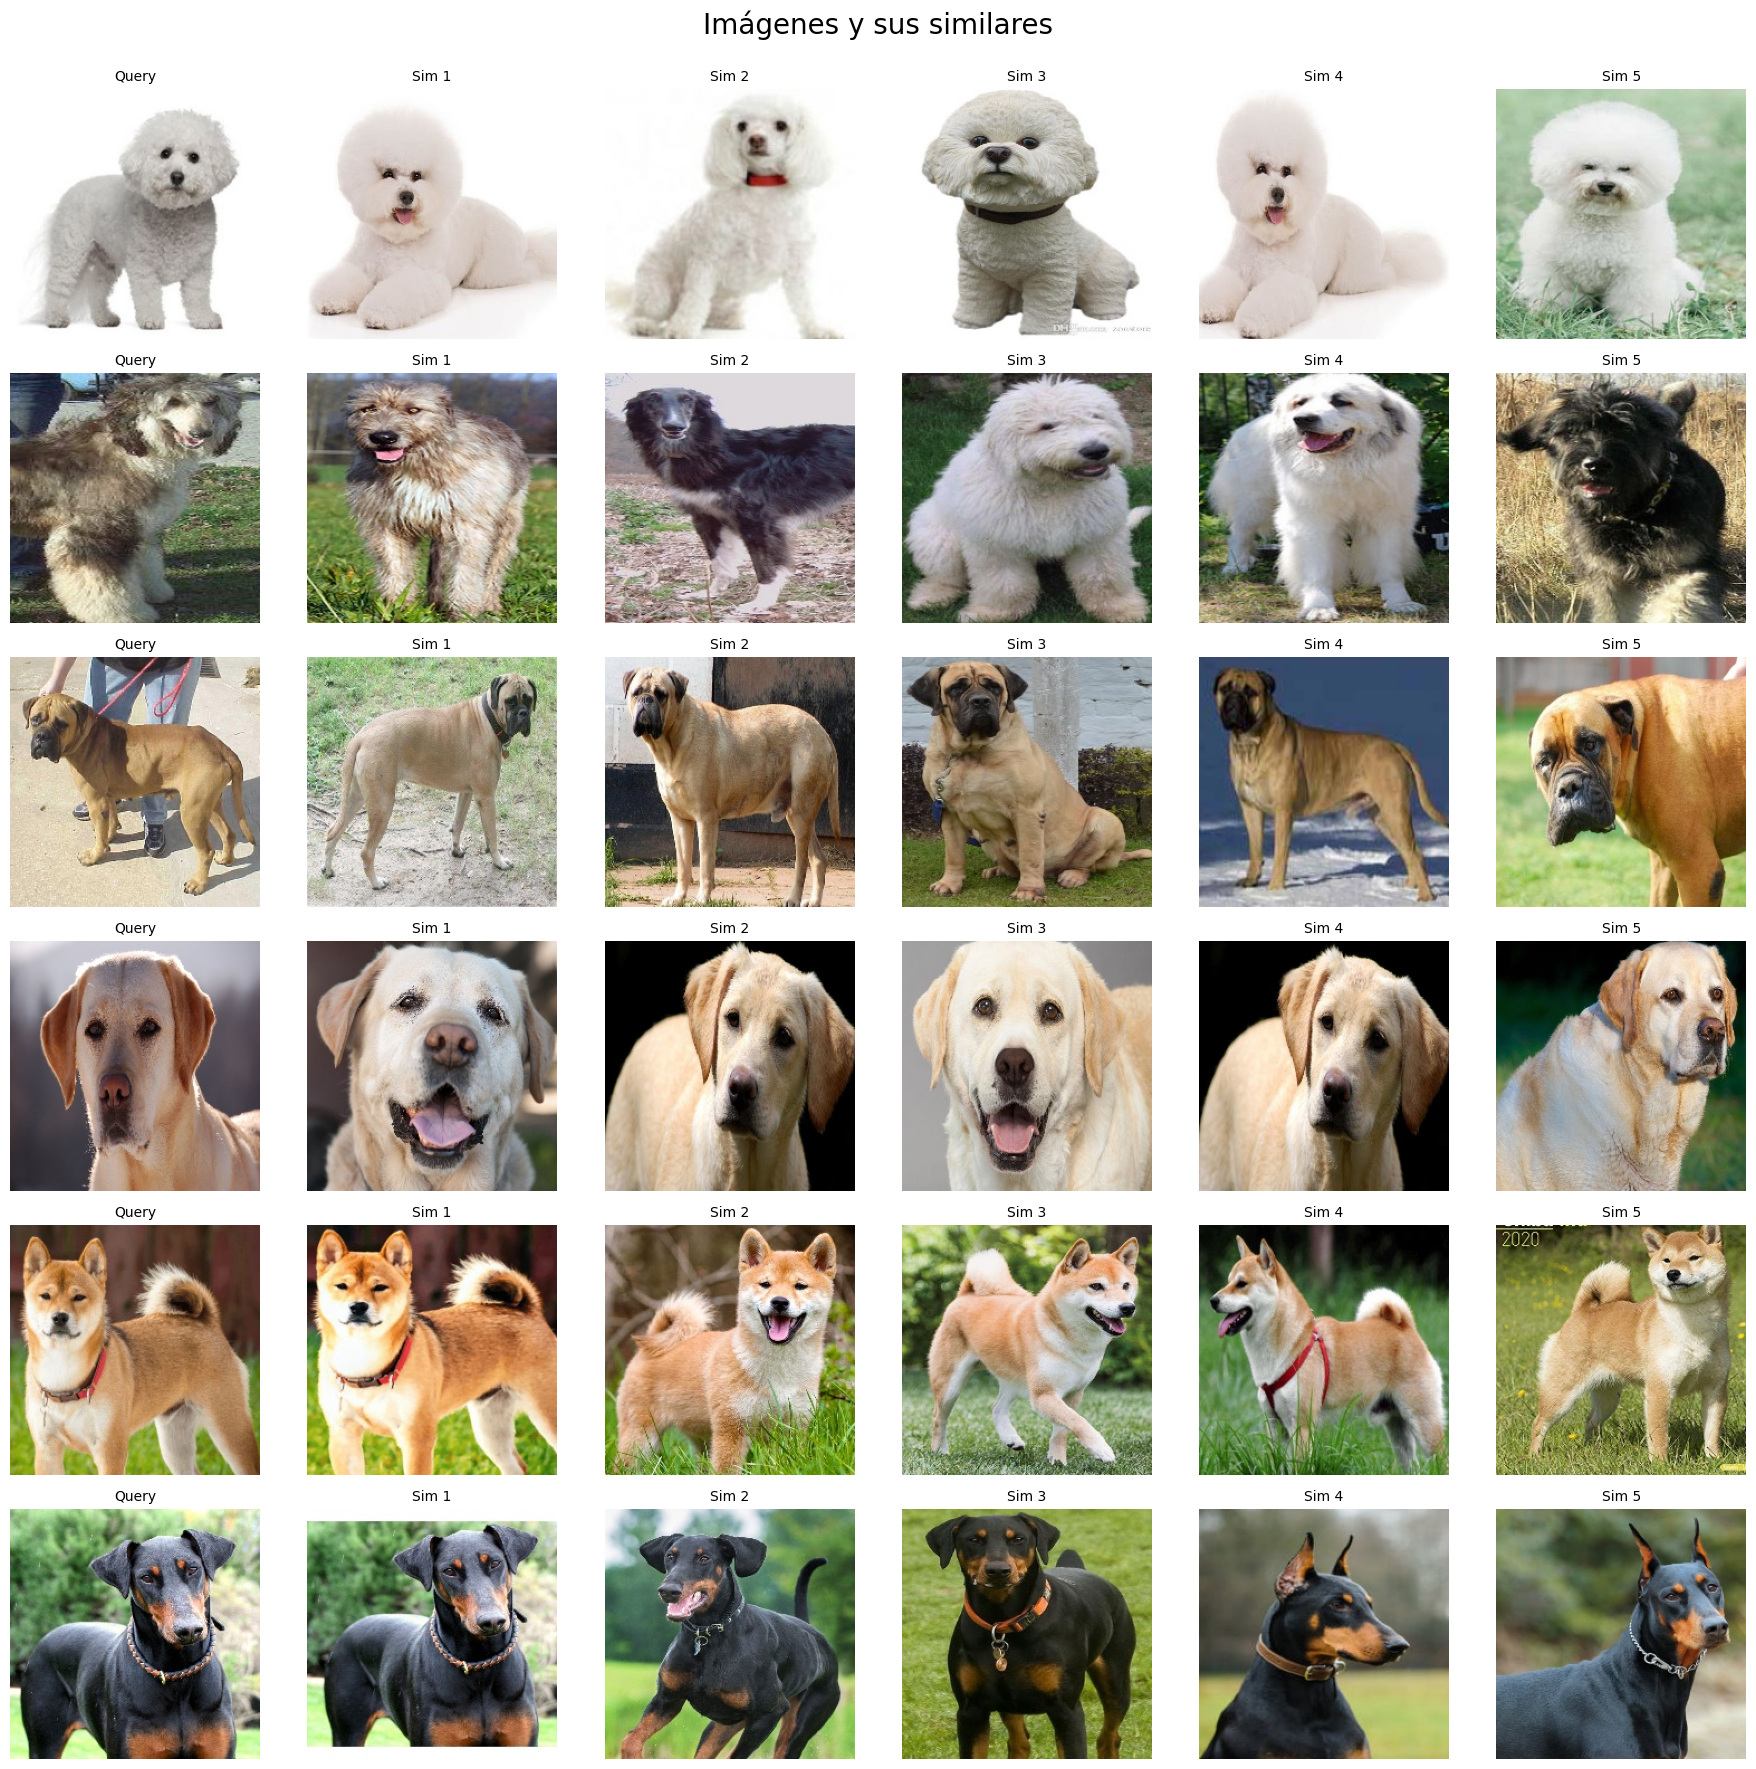

In [11]:
# Elegimos 6 muestras aleatorias
samples = df_dogs_breed.sample(6).reset_index(drop=True)

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 18))
fig.suptitle("Imágenes y sus similares", fontsize=20)

for i in range(6):
    # Imagen consulta
    query_path = samples.iloc[i]['full_path']
    similar_df = search_similar_images(query_path, k=5)

    # Mostrar imagen original
    img = plt.imread(query_path)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Query", fontsize=10)
    axes[i, 0].axis('off')

    # Mostrar similares
    for j in range(5):
        sim_path = similar_df.iloc[j]['full_path']
        sim_img = plt.imread(sim_path)
        axes[i, j+1].imshow(sim_img)
        axes[i, j+1].set_title(f"Sim {j+1}", fontsize=10)
        axes[i, j+1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Desarrollo de la Aplicación en Gradio:

In [23]:
def show_similar_images(uploaded_image):
    # Guardar la imagen temporalmente
    temp_path = "temp_input.jpg"
    uploaded_image.save(temp_path)

    # Obtener imágenes similares
    similares_df = search_similar_images(temp_path, k=10)

    # Convertir las rutas a objetos PIL.Image
    resultado_imagenes = [Image.open(fp) for fp in similares_df['full_path'].values]

    # Devolver imagen original + resultados
    return [uploaded_image] + resultado_imagenes

In [24]:
gr.Interface(
    fn=show_similar_images,
    inputs=gr.Image(type="pil", label="Subí una imagen de perro"),
    outputs=[gr.Image(label="Imagen subida")] + [gr.Image(label=f"Similar {i+1}") for i in range(10)],
    title="Buscador de Razas de Perros",
    description="Subí una imagen de un perro y encontrá las 10 imágenes más similares del dataset."
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


### Clasificación Basada en Similitud y Métrica de Evaluación

In [25]:
def predict_breed_by_majority(query_path, k=10):
    similar_images = search_similar_images(query_path, k)
    predicted_breed = Counter(similar_images['labels']).most_common(1)[0][0]
    return predicted_breed, similar_images

In [26]:
def gradio_interface(img):
    # Guardar imagen temporal para procesar
    temp_path = "temp_input.jpg"
    img.save(temp_path)

    # Predicción
    predicted_breed, similar_df = predict_breed_by_majority(temp_path, k=10)

    # Mostrar imágenes similares
    similar_paths = similar_df['full_path'].tolist()
    similar_imgs = [Image.open(p) for p in similar_paths]

    return predicted_breed, [img] + similar_imgs  # Input + similares

In [27]:
# Definimos interfaz
gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Textbox(label="Raza Predicha"),
        gr.Gallery(label="Imagen de Entrada + 10 Similares", columns=5, height=400)
    ],
    title="Clasificador de Razas de Perros por Similitud",
    description="Subí una imagen de un perro y encuentra las 10 más parecidas del dataset."
).launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [ ]:
def dcg(relevances):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

In [ ]:
def ndcg_at_k(true_label, retrieved_labels, k=10):
    relevances = [1 if label == true_label else 0 for label in retrieved_labels[:k]]
    ideal_relevances = sorted(relevances, reverse=True)
    dcg_val = dcg(relevances)
    idcg_val = dcg(ideal_relevances)
    return dcg_val / idcg_val if idcg_val > 0 else 0.0

In [ ]:
ndcg_scores = []
test_df = df_dogs_breed[df_dogs_breed['data set'] == 'test']
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    query_path = row['full_path']
    true_label = row['labels']
    
    similar_images = search_similar_images(query_path, k=10)
    retrieved_labels = similar_images['labels'].tolist()
    
    score = ndcg_at_k(true_label, retrieved_labels, k=10)
    ndcg_scores.append(score)

average_ndcg = np.mean(ndcg_scores)
print(f"NDCG@10 promedio en el set de prueba: {average_ndcg:.4f}")

100%|██████████| 700/700 [01:00<00:00, 11.66it/s]

NDCG@10 promedio en el set de prueba: 0.9532


## Etapa 2: Entrenamiento y Comparación de Modelos de Clasificación

### Entrenamiento de Modelos: Modelo A (Transfer Learning)

#### Preparacion del entorno

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [5]:
# Paths
train_dir = "train"
valid_dir = "valid"

#### Modelo base

In [6]:
# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImagenNet mean
                         [0.229, 0.224, 0.225])  # ImagenNet std
])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [7]:
# Datasets y DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [8]:
# Modelo base
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 70)  # 70 razas

In [9]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#### Entrenamiento

In [ ]:
model = model.to(device)
# Entrenamiento
def train(model, loader):
    model.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return running_loss / len(loader), acc

In [ ]:
# Validación
def validate(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [ ]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_acc": []
}
for epoch in range(10):  # ajustable
    train_loss, train_acc = train(model, train_loader)
    val_acc = validate(model, valid_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


100%|██████████| 249/249 [00:10<00:00, 22.78it/s]


Epoch 1: Loss=1.7123, Train Acc=0.6612, Val Acc=0.8957


100%|██████████| 249/249 [00:10<00:00, 24.07it/s]


Epoch 2: Loss=0.4904, Train Acc=0.9042, Val Acc=0.9257


100%|██████████| 249/249 [00:10<00:00, 23.99it/s]


Epoch 3: Loss=0.2520, Train Acc=0.9528, Val Acc=0.9243


100%|██████████| 249/249 [00:10<00:00, 24.05it/s]


Epoch 4: Loss=0.1340, Train Acc=0.9781, Val Acc=0.9343


100%|██████████| 249/249 [00:10<00:00, 24.04it/s]


Epoch 5: Loss=0.0760, Train Acc=0.9887, Val Acc=0.9386


100%|██████████| 249/249 [00:10<00:00, 23.87it/s]


Epoch 6: Loss=0.0540, Train Acc=0.9931, Val Acc=0.9329


100%|██████████| 249/249 [00:10<00:00, 24.04it/s]


Epoch 7: Loss=0.0405, Train Acc=0.9964, Val Acc=0.9286


100%|██████████| 249/249 [00:10<00:00, 23.93it/s]


Epoch 8: Loss=0.0384, Train Acc=0.9952, Val Acc=0.9286


100%|██████████| 249/249 [00:10<00:00, 24.03it/s]


Epoch 9: Loss=0.0246, Train Acc=0.9971, Val Acc=0.9300


100%|██████████| 249/249 [00:10<00:00, 23.98it/s]


Epoch 10: Loss=0.0233, Train Acc=0.9960, Val Acc=0.9186


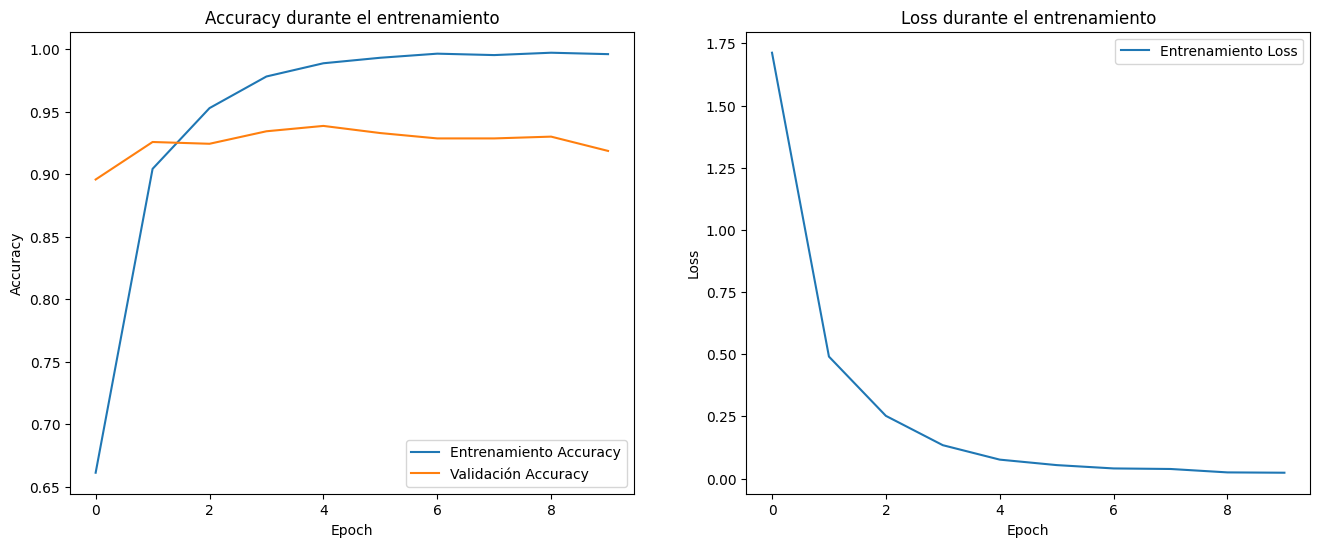

In [43]:
plt.figure(figsize=(16,6))

# Gráfico de Accuracy
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Entrenamiento Accuracy')
plt.plot(history['val_acc'], label='Validación Accuracy')
plt.legend()
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Gráfico de Loss
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Entrenamiento Loss')
plt.legend()
plt.title('Loss durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig("entrenamiento_resultados.png")
plt.show()

In [ ]:
# Guardar modelo
torch.save(model.state_dict(), "modelos/resnet18_finetuned_dogbreeds.pth")

### Entrenamiento de Modelos: Modelo B (CNN)

#### Preparacion del entorno

In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F

In [5]:
torch.cuda.empty_cache()
# Paths
train_dir = "train"
valid_dir = "valid"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Modelo base convolucional

In [6]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 70)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 16, 112, 112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 32, 56, 56)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Entrenamiento

In [7]:
def train_manual(model, loader, optimizer, criterion):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return running_loss / len(loader), acc

In [8]:
def validate_manual(model, loader, criterion):
    model.eval()
    total, correct, running_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(loader)
    val_acc = correct / total
    return val_loss, val_acc

In [11]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [12]:
train_dataset = ImageFolder("train", transform=transform_train)
valid_dataset = ImageFolder("valid", transform=transform_valid)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8)

In [37]:
model = CustomCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(50):
    train_loss, train_acc = train_manual(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_manual(model, valid_loader, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

Epoch 1: Train Loss=4.1049, Acc=0.0446 | Val Loss=3.9465, Acc=0.0800
Epoch 2: Train Loss=3.8901, Acc=0.0794 | Val Loss=3.8059, Acc=0.1071
Epoch 3: Train Loss=3.7567, Acc=0.1038 | Val Loss=3.7060, Acc=0.1243
Epoch 4: Train Loss=3.6528, Acc=0.1280 | Val Loss=3.5929, Acc=0.1629
Epoch 5: Train Loss=3.5577, Acc=0.1471 | Val Loss=3.5134, Acc=0.1714
Epoch 6: Train Loss=3.4609, Acc=0.1676 | Val Loss=3.4484, Acc=0.1714
Epoch 7: Train Loss=3.3747, Acc=0.1830 | Val Loss=3.3647, Acc=0.1900
Epoch 8: Train Loss=3.3058, Acc=0.1914 | Val Loss=3.2992, Acc=0.2014
Epoch 9: Train Loss=3.2402, Acc=0.2065 | Val Loss=3.2270, Acc=0.2071
Epoch 10: Train Loss=3.1763, Acc=0.2210 | Val Loss=3.1879, Acc=0.2257
Epoch 11: Train Loss=3.1219, Acc=0.2299 | Val Loss=3.1362, Acc=0.2286
Epoch 12: Train Loss=3.0760, Acc=0.2389 | Val Loss=3.1011, Acc=0.2443
Epoch 13: Train Loss=3.0340, Acc=0.2467 | Val Loss=3.1023, Acc=0.2414
Epoch 14: Train Loss=2.9954, Acc=0.2616 | Val Loss=3.0871, Acc=0.2371
Epoch 15: Train Loss=2.9684, 

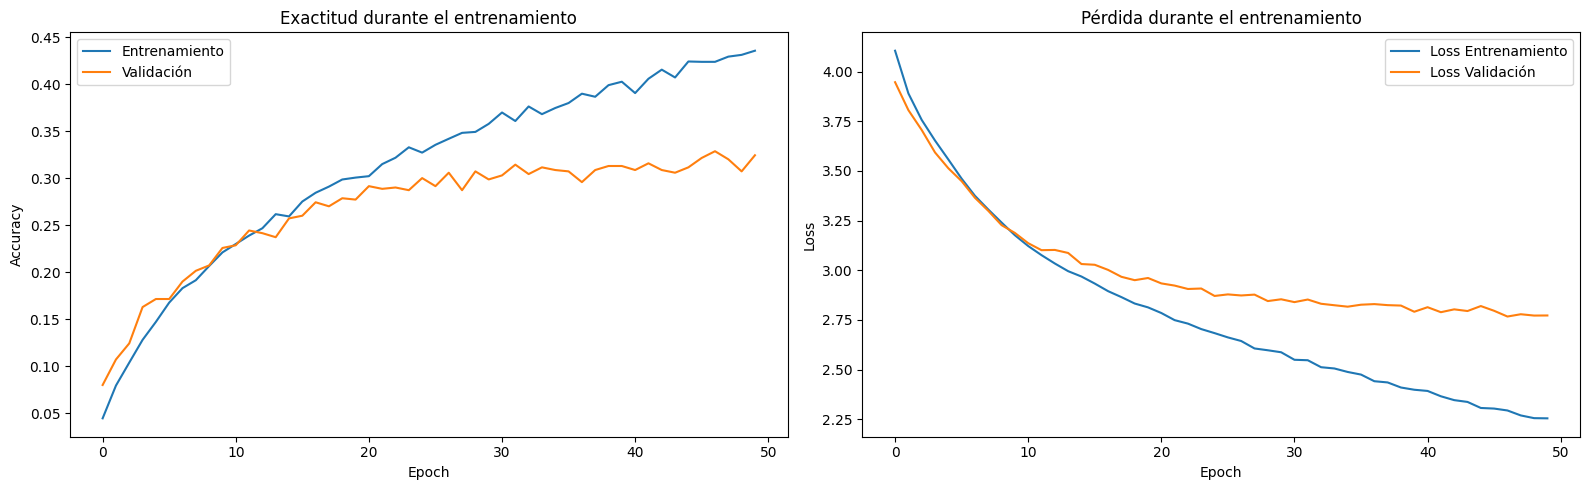

In [38]:
plt.figure(figsize=(16,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Entrenamiento')
plt.plot(history['val_acc'], label='Validación')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Loss Entrenamiento')
plt.plot(history['val_loss'], label='Loss Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("cnn_custom_resultados.png")
plt.show()

In [39]:
torch.save(model.state_dict(), "modelos/custom_cnn_dogbreeds.pth")

### Integración y Selección en la Aplicación:

#### Preparacion del entorno

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
import os

#### Modelos base

In [46]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # reducir tamaño FC
        self.fc2 = nn.Linear(256, 70)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [42]:
def load_resnet18_feature_extractor(pth_path, num_classes=70):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(pth_path, map_location=device))
    model.eval()
    return model.to(device)

In [43]:
def load_custom_cnn():
    model_custom = CustomCNN()
    model_custom.load_state_dict(torch.load("modelos/custom_cnn_dogbreeds.pth", map_location=device))
    model_custom = model_custom.to(device)
    return model.to(device)

#### Embeddings

In [51]:
def extract_embeddings_resnet(model, loader):
    all_embeddings = []
    all_labels = []
    features = nn.Sequential(*list(model.children())[:-1]).to(device)
    features.eval()

    with torch.no_grad():
        for images, labels in loader:
            embeddings = features(images.to(device))
            embeddings = embeddings.view(embeddings.size(0), -1)
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    return all_embeddings, all_labels

def extract_embeddings_custom(model_layers, loader):
    conv1, bn1, conv2, bn2, pool, dropout, fc1, fc2 = model_layers
    conv1.eval()
    bn1.eval()
    conv2.eval()
    bn2.eval()
    fc1.eval()
    fc2.eval()
    dropout.eval()
    pool.eval()

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # Forward manual
            x = pool(F.relu(bn1(conv1(images))))
            x = pool(F.relu(bn2(conv2(x))))
            x = dropout(x)
            x = x.view(x.size(0), -1)
            x = F.relu(fc1(x))
            # Aquí tomamos embeddings antes de la última FC
            all_embeddings.append(x.cpu())
            all_labels.append(labels)

    embeddings = torch.cat(all_embeddings)
    labels = torch.cat(all_labels)
    return embeddings, labels

In [ ]:
# -----------------------
# Ejemplo de uso
# -----------------------
if __name__ == "__main__":
    from torchvision.datasets import ImageFolder
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset = ImageFolder("train", transform=transform)
    valid_dataset = ImageFolder("valid", transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    # Cargar modelos
    model_resnet = load_resnet18_feature_extractor("modelos/resnet18_finetuned_dogbreeds.pth")
    model_custom = load_custom_cnn()

    # Extraer capas para modelo custom
    conv1 = model_custom.conv1
    bn1 = model_custom.bn1
    conv2 = model_custom.conv2
    bn2 = model_custom.bn2
    pool = model_custom.pool
    dropout = model_custom.dropout
    fc1 = model_custom.fc1
    fc2 = model_custom.fc2
    model_layers = [conv1, bn1, conv2, bn2, pool, dropout, fc1, fc2]

    # Extraer embeddings
    print("Extrayendo embeddings ResNet18...")
    train_embeds_resnet, train_labels_resnet = extract_embeddings_resnet(model_resnet, train_loader)

    print("Extrayendo embeddings Custom CNN...")
    train_embeds_custom, train_labels_custom = extract_embeddings_custom(model_layers, train_loader)

    print("Listo.")

Extrayendo embeddings ResNet18...
Extrayendo embeddings Custom CNN...
Listo.


In [54]:

# Guardar embeddings ResNet
if not os.path.exists("embeddings"):
    os.makedirs("embeddings")
np.save("embeddings/train_embeds_resnet.npy", train_embeds_resnet)
np.save("embeddings/train_labels_resnet.npy", train_labels_resnet)

# Guardar embeddings Custom CNN
np.save("embeddings/train_embeds_custom.npy", train_embeds_custom)
np.save("embeddings/train_labels_custom.npy", train_labels_custom)

In [55]:
dimension_resnet = train_embeds_resnet.shape[1]  # 512
index_resnet = faiss.IndexFlatL2(dimension_resnet)
index_resnet.add(train_embeds_resnet)

In [56]:
dimension_custom = train_embeds_custom.shape[1]  # 70 (o lo que sea)
index_custom = faiss.IndexFlatL2(dimension_custom)
index_custom.add(train_embeds_custom)

#### Integracion

In [57]:
def search_similar(query_embed, index, labels, k=5):
    # query_embed debe ser 2D numpy array (1, dim)
    distances, indices = index.search(query_embed, k)
    results = [labels[i] for i in indices[0]]
    return results

In [59]:
train_embeds_resnet = np.load("embeddings/train_embeds_resnet.npy")
train_labels_resnet = np.load("embeddings/train_labels_resnet.npy", allow_pickle=True)

train_embeds_custom = np.load("embeddings/train_embeds_custom.npy")
train_labels_custom = np.load("embeddings/train_labels_custom.npy", allow_pickle=True)

index_resnet = faiss.IndexFlatL2(train_embeds_resnet.shape[1])
index_resnet.add(train_embeds_resnet)

index_custom = faiss.IndexFlatL2(train_embeds_custom.shape[1])
index_custom.add(train_embeds_custom)

In [60]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def get_embedding(image: Image.Image, model_name: str):
    x = transform(image).unsqueeze(0).to(device)  # (1,3,224,224)
    if model_name == "ResNet18":
        with torch.no_grad():
            embedding = model_resnet(x)
    else:  # Custom CNN
        with torch.no_grad():
            embedding = model_custom(x)
    return embedding.cpu().numpy()

In [61]:
def search_and_return(image, model_name, k=5):
    embed = get_embedding(image, model_name)
    if model_name == "ResNet18":
        results = search_similar(embed, index_resnet, train_labels_resnet, k)
    else:
        results = search_similar(embed, index_custom, train_labels_custom, k)

    return results  # lista de nombres o rutas de imagen similares

In [62]:
def gradio_interface(image, model_name):
    results = search_and_return(image, model_name)
    # Aquí podés abrir las imágenes desde las rutas y devolverlas como lista para mostrar
    images_to_show = [Image.open(r) for r in results]
    return images_to_show

iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Image(type="pil"),
        gr.Dropdown(["ResNet18", "CustomCNN"], label="Modelo a usar")
    ],
    outputs=gr.Gallery(label="Imágenes similares"),
    title="Búsqueda por similitud con dos modelos"
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Etapa 3: Pipeline de Detección y Clasificación en Escenas Complejas

### Deteccion de objetos

#### Preparacion del entorno

In [24]:
from ultralytics import YOLO
from PIL import ImageDraw, ImageFont
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import datasets, models

#### Modelos

In [25]:
yolo = YOLO("yolov8s.pt") # yolov8s.pt para más precisión

In [26]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 70)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 16, 112, 112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 32, 56, 56)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [27]:
class DogDetector:
    def __init__(self, model_path="yolov8n.pt", conf_thres=0.5):
        self.model = YOLO(model_path)
        self.conf_thres = conf_thres
        self.dog_class_id = 16  # Clase 'dog' en COCO

    def detect(self, image_path):
        results = self.model(image_path)[0]
        boxes = []
        for box in results.boxes:
            cls = int(box.cls.item())
            conf = box.conf.item()
            if cls == self.dog_class_id and conf >= self.conf_thres:
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                boxes.append((x1, y1, x2, y2))
        return boxes

    def crop_dogs(self, image_path, boxes):
        image = Image.open(image_path).convert("RGB")
        return [image.crop((x1, y1, x2, y2)) for (x1, y1, x2, y2) in boxes]


In [28]:
class DogClassifier:
    def __init__(self, model_type="ResNet18", model_path=None, class_names=None):
        self.model_type = model_type
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.class_names = class_names
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        if model_type == "ResNet18":
            from torchvision.models import resnet18
            self.model = resnet18(pretrained=False)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, len(class_names))
            state_dict = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(state_dict)
            self.model.to(self.device).eval()

        elif model_type == "Custom CNN":
            self.model = CustomCNN()
            state_dict = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(state_dict)
            self.model.to(self.device).eval()

        else:
            raise ValueError(f"Modelo no reconocido: {model_type}")

    def classify(self, pil_image):
        x = self.transform(pil_image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(x)
            pred_idx = logits.argmax(dim=1).item()
        return self.class_names[pred_idx]

In [29]:
def mostrar_detecciones_con_etiquetas(image_path, detector, classifier):
    boxes = detector.detect(image_path)
    crops = detector.crop_dogs(image_path, boxes)
    
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 18)
    except:
        font = ImageFont.load_default()

    for i, (box, crop) in enumerate(zip(boxes, crops)):
        x1, y1, x2, y2 = box
        raza = classifier.classify(crop)

        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
        draw.text((x1, y1 - 20), raza, fill="white", font=font, stroke_width=1, stroke_fill="black")

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Perros detectados y clasificados")
    plt.show()

In [30]:
train_dir = "train"
valid_dir = "valid"

In [31]:
# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImagenNet mean
                         [0.229, 0.224, 0.225])  # ImagenNet std
])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
# Datasets y DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform_val)

#### Detector

In [32]:
detector = DogDetector()

classifier_resnet = DogClassifier(
    model_type="ResNet18",
    model_path="modelos/resnet18_finetuned_dogbreeds.pth",
    class_names=train_dataset.classes
)

classifier_custom = DogClassifier(
    model_type="Custom CNN",
    model_path="modelos/custom_cnn_dogbreeds.pth",
    class_names=train_dataset.classes
)

# Ejecutar
img_path = "dosperros.jpg"
mostrar_detecciones_con_etiquetas(img_path, detector, classifier_resnet)

/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/dosperros.jpg: 352x640 2 dogs, 51.6ms
Speed: 4.5ms preprocess, 51.6ms inference, 142.0ms postprocess per image at shape (1, 3, 352, 640)


NameError: name 'plt' is not defined


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/dosperros.jpg: 352x640 2 dogs, 4.9ms
Speed: 13.7ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


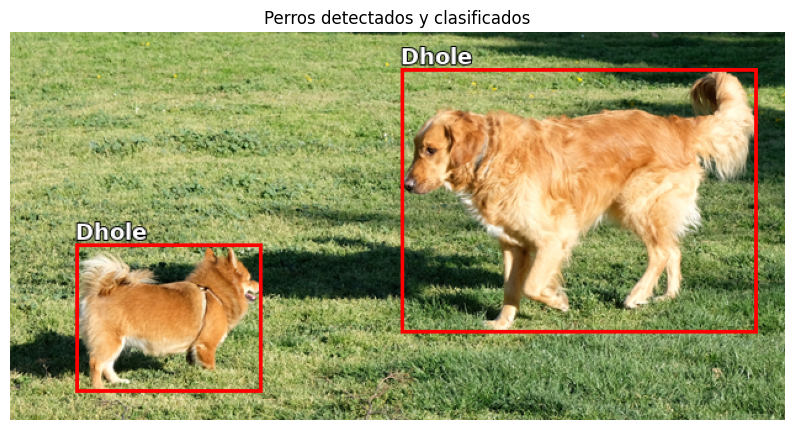

In [ ]:
# Ejecutar
img_path = "dosperros.jpg"
razas = mostrar_detecciones_con_etiquetas(img_path, detector, classifier_custom)

### Creación del Pipeline Completo

In [ ]:
def procesar_imagen(image_path, detector, classifier):
    boxes = detector.detect(image_path)
    crops = detector.crop_dogs(image_path, boxes)

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 18)
    except:
        font = ImageFont.load_default()

    for box, crop in zip(boxes, crops):
        x1, y1, x2, y2 = box
        raza = classifier.classify(crop)
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
        draw.text((x1, y1 - 20), raza, fill="white", font=font, stroke_width=1, stroke_fill="black")

    return image  # Devuelve PIL.Image

In [ ]:
def gradio_pipeline(input_img):
    input_img.save("temp_input.jpg")
    resultado = procesar_imagen("temp_input.jpg", detector, classifier)
    return resultado

In [ ]:
# Inicializar
detector = DogDetector()
classifier = DogClassifier(
    model_type="ResNet18",
    model_path="modelos/resnet18_finetuned_dogbreeds.pth",
    class_names=train_dataset.classes
)

# Interfaz
gr.Interface(
    fn=gradio_pipeline,
    inputs=gr.Image(type="pil", label="Subí una imagen con perros"),
    outputs=gr.Image(type="pil", label="Resultado"),
    title="Clasificador de Razas de Perros con Detección YOLO + Clasificación"
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Etapa 4: Evaluación, Optimización y Herramientas de Anotación

#### Evaluación del Pipeline

In [33]:
from pycocotools.coco import COCO
from pathlib import Path
from pycocotools.cocoeval import COCOeval
import json
import pandas as pd
from ultralytics import YOLO

In [34]:
# Cargar anotaciones COCO
coco_gt = COCO("instances_default.json")

# Crear DataFrame con paths a imágenes
test_dir = "test_complex_images"
test_df = pd.DataFrame({
    'full_path': [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
})

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [35]:
test_df

full_path
0      test_complex_images/perro_caballo_nino.jpg
1             test_complex_images/perro_nieve.jpg
2             test_complex_images/perro_gato.jpeg
3  test_complex_images/perro_disfraz_caballo.jpeg
4          test_complex_images/perro_policia.jpeg
5             test_complex_images/perro_ninos.jpg
6           test_complex_images/perros_arbol.jpeg
7      test_complex_images/perro_gatos_varios.jpg
8     test_complex_images/perro_campo_ovejas.jpeg
9   test_complex_images/perro_campo_mucha_luz.jpg

In [36]:
print(coco_gt.getImgIds())
img_ids = coco_gt.getImgIds()
img_info = coco_gt.loadImgs(img_ids[0])  # o cualquier otro ID
print(img_info)
cats = coco_gt.loadCats(coco_gt.getCatIds())
for c in cats:
    print(c['id'], c['name'])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[{'id': 1, 'width': 1300, 'height': 866, 'file_name': 'perro_caballo_nino.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}]
1 Dalmation
2 Border Collie
3 Golden Retriever
4 Blenheim
5 German Sheperd
6 Doberman
7 Siberian Husky
8 Labrador


In [37]:
cats = coco_gt.loadCats(coco_gt.getCatIds())
for c in cats:
    print(f"{c['id']} → {c['name']}")

1 → Dalmation
2 → Border Collie
3 → Golden Retriever
4 → Blenheim
5 → German Sheperd
6 → Doberman
7 → Siberian Husky
8 → Labrador


In [38]:
def detections_to_coco(detector, classifier, test_df, coco_gt):
    results = []

    # Mapeo de nombres de raza a category_id
    class_name_to_category_id = {
        "Dalmation": 1,
        "Border Collie": 2,
        "Golden Retriever": 3,
        "Blenheim": 4,
        "German Sheperd": 5,
        "Doberman": 6,
        "Siberian Husky": 7,
        "Labrador": 8
    }

    # Mapear nombre de archivo a image_id
    file_name_to_id = {
        img['file_name']: img['id']
        for img in coco_gt.loadImgs(coco_gt.getImgIds())
    }

    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        image_path = row['full_path']
        file_name = os.path.basename(image_path)
        image_id = file_name_to_id.get(file_name, None)
        if image_id is None:
            continue

        # Detectar perros
        pred_boxes = detector.detect(image_path)
        # Recortar cada perro detectado
        crops = detector.crop_dogs(image_path, pred_boxes)
        # Clasificar cada crop
        pred_labels = [classifier.classify(crop) for crop in crops]

        for box, class_name in zip(pred_boxes, pred_labels):
            category_id = class_name_to_category_id.get(class_name, None)
            if category_id is None:
                continue  # ignorar predicciones no reconocidas

            # Convertir [x1, y1, x2, y2] → [x, y, w, h]
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1

            results.append({
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [x1, y1, w, h],
                "score": 1.0  # o el score real si lo tenés
            })

    return results

In [39]:
def evaluar_pipeline(detector, classifier, coco_gt, test_df):
    results = detections_to_coco(detector, classifier, test_df, coco_gt)

    with open("detections.json", "w") as f:
        json.dump(results, f)

    coco_dt = coco_gt.loadRes("detections.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return {
        "mAP": coco_eval.stats[0],
        "Precision@0.5": coco_eval.stats[1],
        "Recall": coco_eval.stats[8],
        "AP_medium": coco_eval.stats[4],
        "AP_large": coco_eval.stats[5],
    }

In [40]:
detector = DogDetector()
classifier = classifier_resnet  # o classifier_custom

resultados = evaluar_pipeline(detector, classifier, coco_gt, test_df)

print("Resultados:")
for k, v in resultados.items():
    print(f"{k}: {v:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_caballo_nino.jpg: 448x640 2 persons, 1 dog, 1 horse, 1 cow, 53.1ms
Speed: 1.6ms preprocess, 53.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 10%|█         | 1/10 [00:00<00:01,  6.59it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_nieve.jpg: 448x640 1 elephant, 1 bear, 4.5ms
Speed: 1.1ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_gato.jpeg: 384x640 1 cat, 4 dogs, 51.7ms
Speed: 0.9ms preprocess, 51.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_disfraz_caballo.jpeg: 640x384 1 person, 1 horse, 50.0ms
Speed: 1.1ms preprocess, 50.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)


 40%|████      | 4/10 [00:00<00:00, 15.43it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_policia.jpeg: 352x640 1 person, 1 dog, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perros_arbol.jpeg: 640x640 2 dogs, 5.0ms
Speed: 1.7ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_gatos_varios.jpg: 480x640 3 birds, 1 cat, 5 dogs, 52.0ms
Speed: 1.4ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 80%|████████  | 8/10 [00:00<00:00, 23.14it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_campo_ovejas.jpeg: 320x640 1 dog, 6 sheeps, 51.6ms
Speed: 1.8ms preprocess, 51.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_campo_mucha_luz.jpg: 448x640 1 sheep, 2 cows, 1 elephant, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


100%|██████████| 10/10 [00:00<00:00, 13.52it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

### Optimización de Modelos

#### Exportación a formato optimizado

In [48]:
from torchvision.models import resnet18
import onnxruntime as ort
import onnx
import numpy as np

In [43]:
# Cargar el modelo entrenado (ajustá el path si es distinto)
model = resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 70)  # 70 clases de razas

/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/CV-Dog-breeds/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [44]:
# Cargar pesos
state_dict = torch.load("modelos/resnet18_finetuned_dogbreeds.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()  # Importante: eval mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
# Crear dummy input
dummy_input = torch.randn(1, 3, 224, 224)

In [46]:
# Exportar a ONNX
torch.onnx.export(
    model,
    dummy_input,
    "dog_classifier_resnet18.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

print("✅ Modelo exportado a 'dog_classifier_resnet18.onnx'")

✅ Modelo exportado a 'dog_classifier_resnet18.onnx'


In [49]:
session = ort.InferenceSession("resnet18_dogbreeds_70classes.onnx")
input_data = np.random.randn(1, 3, 224, 224).astype(np.float32)

output = session.run(None, {"input": input_data})
print("Predicción ONNX:", output[0].shape)  # Debería ser (1, 70)

onnx_model = onnx.load("dog_classifier_resnet18.onnx")
onnx.checker.check_model(onnx_model)
print("✅ El modelo ONNX es válido.")

Predicción ONNX: (1, 70)
✅ El modelo ONNX es válido.


In [50]:
# Transformaciones (mismo preprocessing que en entrenamiento)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class_names = train_dataset.classes

# Cargar imagen y preprocesar
image = Image.open("test/Afghan/01.jpg").convert("RGB")
input_tensor = transform(image).unsqueeze(0).numpy()

# Cargar modelo ONNX con ONNX Runtime
session = ort.InferenceSession("dog_classifier_resnet18.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Inferencia
outputs = session.run([output_name], {input_name: input_tensor})
pred = np.argmax(outputs[0])
print("🐶 Clase predicha:", class_names[pred])

🐶 Clase predicha: Afghan


### Script de Anotación Automática:

In [51]:
import torchvision.transforms as transforms
import torch
import os
import json
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [67]:
# Configuraciones
input_folder = "test"
output_yolo = "labels_yolo"
output_coco = "annotations_coco.json"

#### Modelos

In [58]:
# Cargar modelos
detector = DogDetector()
classifier = DogClassifier(
    model_type="ResNet18",
    model_path="modelos/resnet18_finetuned_dogbreeds.pth",
    class_names = train_dataset.classes
)

In [59]:
# Inicializar COCO
coco_dict = {
    "info": {"description": "Anotaciones automáticas"},
    "images": [],
    "annotations": [],
    "categories": [{"id": i+1, "name": name} for i, name in enumerate(classifier.class_names)]
}

annotation_id = 1

In [70]:
image_paths = list(Path(input_folder).rglob("*.jpg")) + \
              list(Path(input_folder).rglob("*.jpeg")) + \
              list(Path(input_folder).rglob("*.png"))

for image_id, img_path in enumerate(tqdm(image_paths)):
    img_path = str(img_path)
    image_name = os.path.basename(img_path)

    img_path = os.path.join(input_folder, image_name)
    image = Image.open(img_path).convert("RGB")
    boxes = detector.detect(img_path)
    crops = detector.crop_dogs(img_path, boxes)

    coco_dict["images"].append({
        "id": image_id,
        "file_name": image_name,
        "width": image.width,
        "height": image.height
    })

    with open(os.path.join(output_yolo, Path(image_name).stem + ".txt"), "w") as yolo_file:
        for box, crop in zip(boxes, crops):
            x1, y1, x2, y2 = box
            raza = classifier.classify(crop)
            class_id = classifier.class_names.index(raza)

            # YOLOv5 formato: class_id x_center y_center width height (normalizados)
            x_center = (x1 + x2) / 2 / image.width
            y_center = (y1 + y2) / 2 / image.height
            width = (x2 - x1) / image.width
            height = (y2 - y1) / image.height
            yolo_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

            # COCO formato
            coco_dict["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": class_id + 1,  # COCO usa IDs desde 1
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "area": (x2 - x1) * (y2 - y1),
                "iscrowd": 0
            })
            annotation_id += 1

# Guardar COCO
with open(output_coco, "w") as f:
    json.dump(coco_dict, f, indent=4)

print("✅ Anotaciones generadas exitosamente.")

  0%|          | 0/10 [00:00<?, ?it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_caballo_nino.jpg: 448x640 2 persons, 1 dog, 1 horse, 1 cow, 4.8ms
Speed: 1.7ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_nieve.jpg: 448x640 1 elephant, 1 bear, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_gato.jpeg: 384x640 1 cat, 4 dogs, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_disfraz_caballo.jpeg: 640x384 1 person, 1 horse, 5.2ms
Speed: 0.9ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /home/franco/Es

 50%|█████     | 5/10 [00:00<00:00, 47.00it/s]


image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_ninos.jpg: 448x640 3 persons, 1 dog, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perros_arbol.jpeg: 640x640 2 dogs, 5.1ms
Speed: 1.8ms preprocess, 5.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_gatos_varios.jpg: 480x640 3 birds, 1 cat, 5 dogs, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer Vision/CV-Dog-Breeds/test_complex_images/perro_campo_ovejas.jpeg: 320x640 1 dog, 6 sheeps, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/franco/Escritorio/TUIA/Computer

100%|██████████| 10/10 [00:00<00:00, 15.69it/s]

✅ Anotaciones generadas exitosamente.
